#**Introduction**

In this section, we will import some libraries and connect to Google Drive for data access

In [1]:
import io
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from keras.callbacks import EarlyStopping

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from time import time

In [4]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Let's now open the file "divina_commedia.txt" to analize it and print its length and the first 1000 characters:

In [5]:
with io.open("/content/drive/MyDrive/AML/Assignement4/divina_commedia.txt", encoding='utf-8') as f:
  text = f.read().lower()

print(f"text lenth: {len(text)}")
print("First 1000 characters:\n\n")
text[0:1000]

text lenth: 558240
First 1000 characters:




"inferno\n\n\n\ninferno: canto i\n\n\nnel mezzo del cammin di nostra vita\n  mi ritrovai per una selva oscura\n  che' la diritta via era smarrita.\n\nahi quanto a dir qual era e` cosa dura\n  esta selva selvaggia e aspra e forte\n  che nel pensier rinova la paura!\n\ntant'e` amara che poco e` piu` morte;\n  ma per trattar del ben ch'i' vi trovai,\n  diro` de l'altre cose ch'i' v'ho scorte.\n\nio non so ben ridir com'i' v'intrai,\n  tant'era pien di sonno a quel punto\n  che la verace via abbandonai.\n\nma poi ch'i' fui al pie` d'un colle giunto,\n  la` dove terminava quella valle\n  che m'avea di paura il cor compunto,\n\nguardai in alto, e vidi le sue spalle\n  vestite gia` de' raggi del pianeta\n  che mena dritto altrui per ogne calle.\n\nallor fu la paura un poco queta\n  che nel lago del cor m'era durata\n  la notte ch'i' passai con tanta pieta.\n\ne come quei che con lena affannata\n  uscito fuor del pelago a la riva\n  si volge a l'acqua perigliosa e guata,\n\ncosi` l'animo mio, 

Let's now create two dictionaries:
- Character-to-Index Mapping: Maps each character in the text to a unique numerical index
- Index-to-Character Mapping: Maps each index back to its corresponding character

In [6]:
chars = sorted(list(set(text)))
num_chars = len(chars)
print(f"Total chars: {chars},\nNumber of chars: {num_chars}\n\n")

char_indices = dict((c,i) for i, c in enumerate(chars))
indices_char = dict((i,c) for i,c in enumerate(chars))

print(f"Dictionary character-index: {char_indices}")
print(f"Dictionary character-index: {indices_char}")


Total chars: ['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', ':', ';', '<', '>', '?', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y', 'z'],
Number of chars: 40


Dictionary character-index: {'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, ':': 10, ';': 11, '<': 12, '>': 13, '?': 14, '`': 15, 'a': 16, 'b': 17, 'c': 18, 'd': 19, 'e': 20, 'f': 21, 'g': 22, 'h': 23, 'i': 24, 'j': 25, 'l': 26, 'm': 27, 'n': 28, 'o': 29, 'p': 30, 'q': 31, 'r': 32, 's': 33, 't': 34, 'u': 35, 'v': 36, 'x': 37, 'y': 38, 'z': 39}
Dictionary character-index: {0: '\n', 1: ' ', 2: '!', 3: '"', 4: "'", 5: '(', 6: ')', 7: ',', 8: '-', 9: '.', 10: ':', 11: ';', 12: '<', 13: '>', 14: '?', 15: '`', 16: 'a', 17: 'b', 18: 'c', 19: 'd', 20: 'e', 21: 'f', 22: 'g', 23: 'h', 24: 'i', 25: 'j', 26: 'l', 27: 'm', 28: 'n', 29: 'o', 30: 'p', 31: 'q', 32: 'r', 33: 's', 34: 't', 35: 'u', 36: 'v', 37: 'x', 38: 'y', 39: 'z'}


Let's define a function (so we can call it in a different moment) that creates two lists:
- *Sentences*: each contanins 30 (=maxlen) characters, extracted from the text with a step size of 3
- *Next_char*: The character following each sentence


For a given index "i", "sentences[i]" contains the sentence starting from position "i" in the text, while next_char[i] holds the next character of the sentence, the character in position "i+maxlen"

In [7]:
def generate_sequence (text, maxlen, step):
  sentences = []
  next_char = []

  for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i:i + maxlen])  #doesn't take the character in position (i+maxlen)
    next_char.append(text[i + maxlen])

  return sentences, next_char

In [8]:
ref_maxlen = 30
step = 3

ref_sentences, ref_next_char = generate_sequence (text, ref_maxlen, step)

print (f"Number of sequences: {len(ref_sentences)}")
print("Let's print an example of a sentence and its next character:")
print(f"Sentence 11: {ref_sentences[11]}")
print(f"Next character of the sentence: {ref_next_char[11]}")

Number of sequences: 186070
Let's print an example of a sentence and its next character:
Sentence 11:  mezzo del cammin di nostra vi
Next character of the sentence: t


Let's create now the input and the output for our neural network:
- *Input*: A 3D vector of size (len(sentences), maxlen, len(chars)), where each instance is a one-hot encoded matrix representing a sentence. Each row corresponds to a position in the sentence, and the column index with value 1 indicates the character in that position

- *Output*: A 2D matrix of size (len(sentences), len(chars)). For each instance, the column index with value 1 corresponds to the predicted next character

In [9]:
def one_hot_encode (sentences, maxlen, chars, next_char):
  x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
  y = np.zeros((len(sentences), len(chars)), dtype=bool)

  for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
      x[i, t, char_indices[char]] = 1
    y [i, char_indices[next_char[i]]] = 1

  return x,y

ref_x, ref_y = one_hot_encode (ref_sentences, ref_maxlen, chars, ref_next_char)

print(ref_x.shape)
print(ref_y.shape)

(186070, 30, 40)
(186070, 40)


Let's also divide the text in a training, validation a test datasets:

In [10]:
ref_x_train, ref_x_test, ref_y_train, ref_y_test = train_test_split(ref_x, ref_y, test_size=0.2, random_state=42)

print(ref_x_train.shape)
print(ref_y_train.shape)
print(ref_x_test.shape)
print(ref_y_test.shape)

(148856, 30, 40)
(148856, 40)
(37214, 30, 40)
(37214, 40)


Let's also define some functions that we are going to use later to evaluate the training phase with the validation set:

In [11]:
def plot_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

#**Reference Model**

Let's now define the model that we saw during class, a model that takes a sentence as an input and learns to predict the next character

In [13]:
model = Sequential()

model.add(LSTM(128, input_shape=(ref_maxlen, len(chars))))
model.add(Dense(len(chars), activation="softmax"))

optimizer = keras.optimizers.RMSprop(learning_rate=0.01)

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          86,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,688 (358.16 KB)

 Trainable params: 91,688 (358.16 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
start=time()
history = model.fit(ref_x_train, ref_y_train, batch_size = 2048, epochs = 20, validation_split = 0.2)
time_reference = time() - start

Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.1602 - loss: 3.0951 - val_accuracy: 0.2760 - val_loss: 2.4269
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3004 - loss: 2.3167 - val_accuracy: 0.2885 - val_loss: 2.2834
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3536 - loss: 2.0658 - val_accuracy: 0.3713 - val_loss: 2.0067
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3901 - loss: 1.9242 - val_accuracy: 0.3920 - val_loss: 1.9040
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4167 - loss: 1.8315 - val_accuracy: 0.4105 - val_loss: 1.8548
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4323 - loss: 1.7700 - val_accuracy: 0.4182 - val_loss: 1.8163
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4506 - loss: 1.7118 - val_accuracy: 0.4178 - val_loss: 1.8017
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.4617 - loss: 1.6779 - val_accuracy: 0.4382 - v

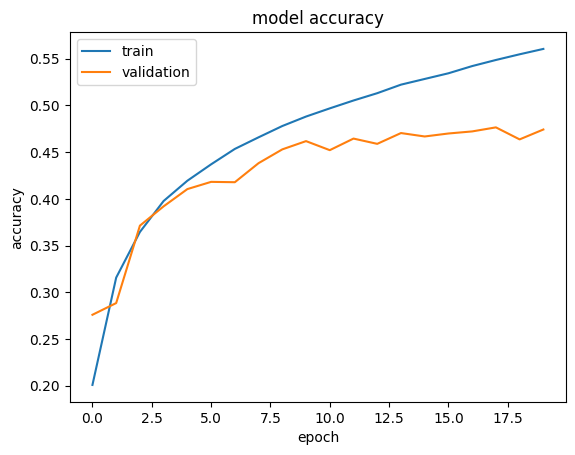

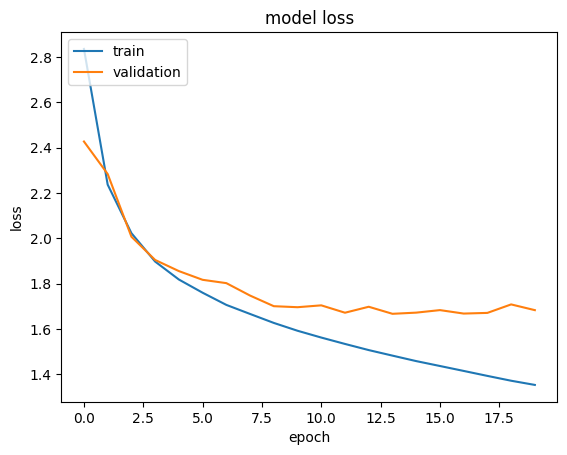

In [15]:
plot_accuracy(history)
plot_loss(history)

From both of the graphics, we can see that the model is clearly overfitting the training dataset, because there is a large gap between the training and the validation curves, so we may think to add later some regularization terms.

Let's now use the test set to evaluate the model:

In [16]:
print("Evaluation of the first model: ")
model_loss, model_accuracy = model.evaluate (ref_x_test, ref_y_test, verbose=0)
print(f"Test loss: {model_loss}, Test accuracy: {model_accuracy}")

Evaluation of the first model: 
Test loss: 1.694904088973999, Test accuracy: 0.4696350693702698


We confirm that the model is not so good at the generalization task, since the test accuracy is way less than the training accuracy

#**Fine Tuning "maxlen"**
Let's now try to find the best value for the hyperprameter "**maxlen**", with the reference model. After some tests, I found that a nice tradeoff between the dimension of the dataset and the model accuracy for the value of "step" was "2"

In [17]:
maxlens = [15, 25, 50, 70, 90, 100]
new_step = 2

max_acc = 0
best_maxlen = 0

model_accuracy = []

In [18]:
for temp_maxlen in maxlens:

  print(f"\n\n\n***MAXLEN: {temp_maxlen}***\n")

  temp_sentences, temp_next_char = generate_sequence (text, temp_maxlen, new_step)
  temp_x, temp_y = one_hot_encode(temp_sentences, temp_maxlen, chars, temp_next_char)
  temp_x_train, temp_x_test, temp_y_train, temp_y_test = train_test_split(temp_x, temp_y, test_size=0.2, random_state=42)

  temp_model = Sequential()
  temp_model.add(LSTM(128, input_shape=(temp_maxlen, len(chars))))
  temp_model.add(Dense(len(chars), activation="softmax"))


  temp_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
  temp_model.compile(loss="categorical_crossentropy", optimizer=temp_optimizer, metrics=["accuracy"])

  temp_history = temp_model.fit(temp_x_train, temp_y_train, batch_size=2048, epochs = 20, validation_split=0.2)

  temp_model_loss, temp_model_accuracy = temp_model.evaluate (temp_x_test, temp_y_test, verbose=0)
  model_accuracy.append(temp_model_accuracy)

  if (temp_model_accuracy > max_acc):

    max_acc = temp_model_accuracy
    best_maxlen = temp_maxlen
    final_model = temp_model
    final_history = temp_history
    final_model_loss, final_model_accuracy = temp_model_loss, temp_model_accuracy

print(f"Best maxlen value: {best_maxlen}, accuracy: {final_model_accuracy}, loss: {final_model_loss}")




***MAXLEN: 15***

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.1891 - loss: 2.9248 - val_accuracy: 0.3106 - val_loss: 2.2274
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3399 - loss: 2.1179 - val_accuracy: 0.3673 - val_loss: 1.9931
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3891 - loss: 1.9208 - val_accuracy: 0.3898 - val_loss: 1.9027
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4177 - loss: 1.8223 - val_accuracy: 0.4177 - val_loss: 1.8275
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4433 - loss: 1.7418 - val_accuracy: 0.4370 - val_loss: 1.7592
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4583 - loss: 1.6864 - val_accuracy: 0.4435 - val_loss: 1.7433
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4739 - loss: 1.6387 - val_accuracy: 0.4551 - val_loss: 1.7107
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4880 - loss: 1.5930 - val

Let's now generate a graph showing the relation between maxlen and the accuracy of the model on the test set:

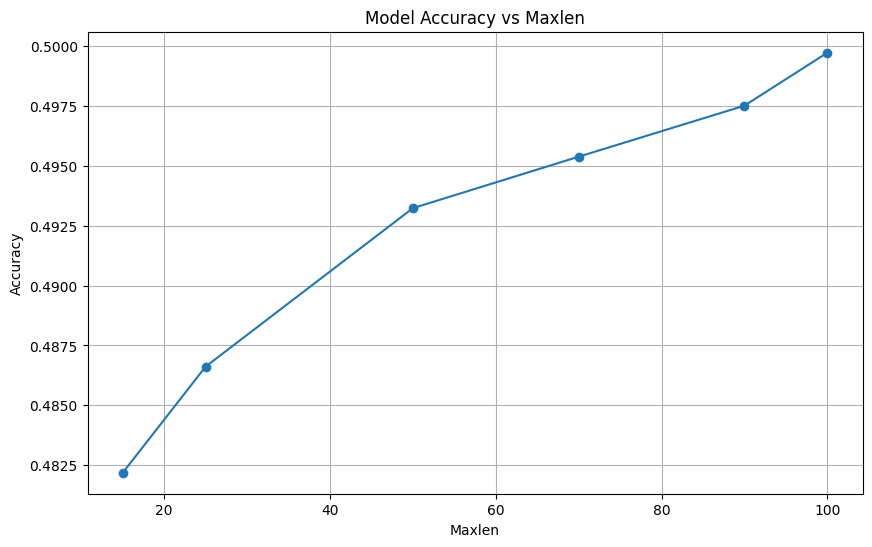

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(maxlens, model_accuracy, marker='o')
plt.title('Model Accuracy vs Maxlen')
plt.xlabel('Maxlen')
plt.ylabel('Accuracy')
plt.grid(True)

As we can see, the accuracy of the model grows as maxlen grows until "100", so we can think that this is the best value to help the model to understand the text

Now that we found that the best value is 100, we can prepare the data with this value:

In [21]:
maxlen = 100

sentences, next_char = generate_sequence (text, maxlen, new_step)

print (f"Number of sequences: {len(sentences)}")
print("Let's print an example of a sentence and its next character:")
print(f"Sentence 11: {sentences[11]}")
print(f"Next character of the sentence: {next_char[11]}")

x, y = one_hot_encode(sentences, maxlen, chars, next_char)

print(x.shape)
print(y.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Number of sequences: 279070
Let's print an example of a sentence and its next character:
Sentence 11: nto i


nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via
Next character of the sentence:  
(279070, 100, 40)
(279070, 40)
(223256, 100, 40)
(223256, 40)
(55814, 100, 40)
(55814, 40)


#**First Model**
Let's try to add some neurons in the LSTM layer to increase the model capacity; since we saw that the model was already overfitting, let's try to add some regularization terms, such as EarlyStopping and Dropout. We are also going to increase the number of epochs

In [22]:
first_model = Sequential()
first_model.add(LSTM(256, input_shape=(maxlen, len(chars))))
first_model.add(Dropout(0.2))
first_model.add(Dense(len(chars), activation='softmax'))

first_model.summary()

first_optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

first_model.compile(loss='categorical_crossentropy', optimizer=first_optimizer, metrics=['accuracy'])

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 256)                 │         304,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 40)                  │          10,280 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 314,408 (1.20 MB)

 Trainable params: 314,408 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
start_first = time()
first_history = first_model.fit(x_train, y_train, batch_size=2048, epochs = 30, validation_split=0.2, callbacks=[early_stopping])
time_first = time() - start_first

Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 186ms/step - accuracy: 0.1701 - loss: 3.3311 - val_accuracy: 0.3120 - val_loss: 2.3268
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - accuracy: 0.3203 - loss: 2.2121 - val_accuracy: 0.3590 - val_loss: 2.0214
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 187ms/step - accuracy: 0.3709 - loss: 1.9912 - val_accuracy: 0.4010 - val_loss: 1.8797
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 181ms/step - accuracy: 0.4064 - loss: 1.8653 - val_accuracy: 0.4176 - val_loss: 1.8181
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 180ms/step - accuracy: 0.4314 - loss: 1.7824 - val_accuracy: 0.4447 - val_loss: 1.7458
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - accuracy: 0.4487 - loss: 1.7194 - val_accuracy: 0.4573 - val_loss: 1.6902
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 186ms/step - accuracy: 0.4651 - loss: 1.6699 - val_accuracy: 0.4711 - val_loss: 1.6470
Epoch 8/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 185ms/step - accuracy: 0.4793 - loss: 1.6208 - val_accu

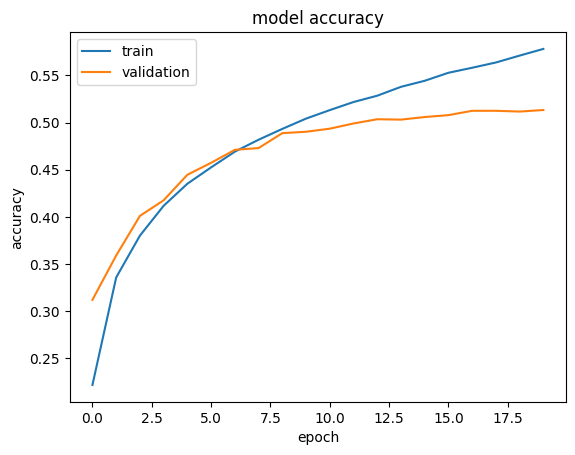

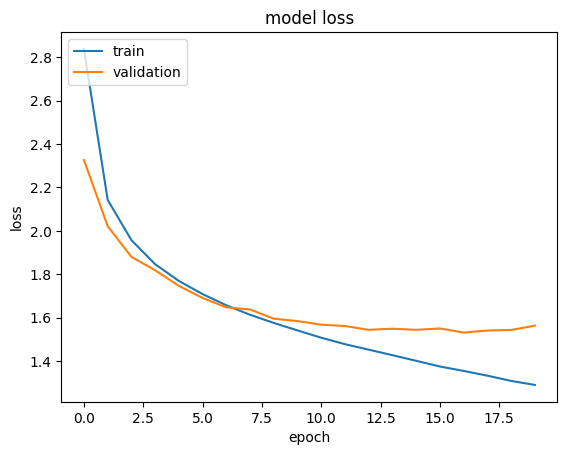

In [24]:
plot_accuracy(first_history)
plot_loss(first_history)

From the graphs we can see that the model it's overfitting less than the previous one, but we can try to do a better job. Let's now evaluate the model on the test set:

In [25]:
print("Evaluation of the first model: ")
first_model_loss, first_model_accuracy = first_model.evaluate (x_test, y_test, verbose=0)
print(f"Test loss: {first_model_loss}, Test accuracy: {first_model_accuracy}")

Evaluation of the first model: 
Test loss: 1.534663438796997, Test accuracy: 0.5098004341125488


From the accuracy on the test dataset we can confirm that this model works better in generalization task

#**Second Model**
Let's try to obtain a second more complex model: here we define a second model with two layers of LSTM to increase the capability to capture long-term dependencies within sequences. We are also going to decrease the batch size so we can encrease the number of weight updates for each epoch

In [26]:
second_model = Sequential()
second_model.add(LSTM(256, return_sequences=True, input_shape=(maxlen, len(chars))))
second_model.add(Dropout(0.2))
second_model.add(LSTM(128))
second_model.add(Dropout(0.2))
second_model.add(Dense(len(chars), activation='softmax'))

second_model.summary()

second_optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
second_model.compile(loss='categorical_crossentropy', optimizer=second_optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 100, 256)            │         304,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 40)                  │           5,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 506,408 (1.93 MB)

 Trainable params: 506,408 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
start_second = time()
second_history = second_model.fit(x_train, y_train, batch_size=256, epochs = 30, validation_split=0.2, callbacks=[early_stopping])
time_second = time() - start_second

Epoch 1/30
698/698 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.1839 - loss: 2.9716 - val_accuracy: 0.3277 - val_loss: 2.1133
Epoch 2/30
698/698 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.3495 - loss: 2.0677 - val_accuracy: 0.4165 - val_loss: 1.8094
Epoch 3/30
698/698 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.4153 - loss: 1.8321 - val_accuracy: 0.4506 - val_loss: 1.7069
Epoch 4/30
698/698 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.4452 - loss: 1.7315 - val_accuracy: 0.4788 - val_loss: 1.6193
Epoch 5/30
698/698 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4699 - loss: 1.6534 - val_accuracy: 0.4904 - val_loss: 1.5810
Epoch 6/30
698/698 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.4827 - loss: 1.6111 - val_accuracy: 0.5014 - val_loss: 1.5421
Epoch 7/30
698/698 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.4938 - loss: 1.5703 - val_accuracy: 0.5068 - val_loss: 1.5307
Epoch 8/30
698/698 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.5026 - loss: 1.5381 - 

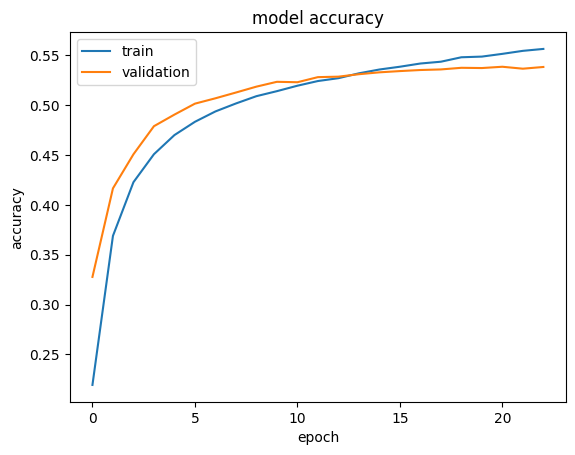

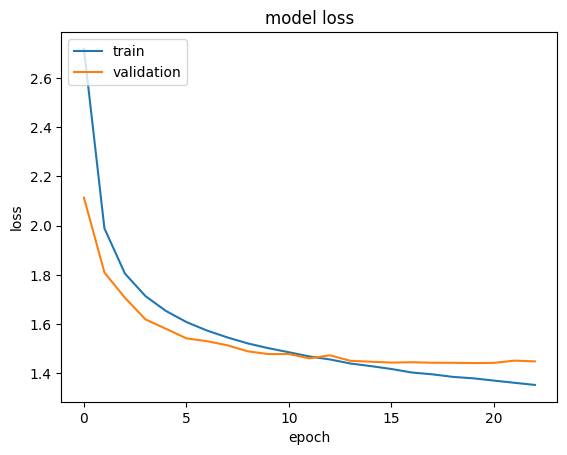

In [28]:
plot_accuracy(second_history)
plot_loss(second_history)

Let's now evaluate the model with the test set:

In [29]:
print("Evaluation of the second model: ")
second_model_loss, second_model_accuracy = second_model.evaluate (x_test, y_test, verbose=0)
print(f"Test loss: {second_model_loss}, Test accuracy: {second_model_accuracy}")

Evaluation of the second model: 
Test loss: 1.4409589767456055, Test accuracy: 0.5347941517829895


The accuracy over the test set has increased compare to before, and the model is less overfitting

#**Third Model**
Let's now try a different approach: let's try to add another layer of LSTM but with in general many fewer parameters, so the new model will be smaller:


In [30]:
third_model = Sequential()

third_model.add(LSTM(128, return_sequences=True, input_shape=(maxlen, len(chars))))
third_model.add(Dropout(0.2))

third_model.add(LSTM(64, return_sequences=True))
third_model.add(Dropout(0.2))

third_model.add(LSTM(32))
third_model.add(Dropout(0.2))


third_model.add(Dense(len(chars), activation='softmax'))

third_optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

third_model.compile(loss='categorical_crossentropy', optimizer=third_optimizer, metrics=['accuracy'])

third_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                       │ (None, 100, 128)            │          86,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 100, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 40)                  │           1,320 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 149,672 (584.66 KB)

 Trainable params: 149,672 (584.66 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
start_third = time()
third_history = third_model.fit(x_train, y_train, batch_size=256, epochs = 30, validation_split=0.2, callbacks=[early_stopping])
time_third = time() - start_third

Epoch 1/30
698/698 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.1971 - loss: 2.8755 - val_accuracy: 0.3456 - val_loss: 2.0598
Epoch 2/30
698/698 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.3459 - loss: 2.0665 - val_accuracy: 0.4042 - val_loss: 1.8648
Epoch 3/30
698/698 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.3954 - loss: 1.9066 - val_accuracy: 0.4331 - val_loss: 1.7561
Epoch 4/30
698/698 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.4174 - loss: 1.8269 - val_accuracy: 0.4460 - val_loss: 1.7081
Epoch 5/30
698/698 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.4325 - loss: 1.7746 - val_accuracy: 0.4646 - val_loss: 1.6571
Epoch 6/30
698/698 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.4475 - loss: 1.7315 - val_accuracy: 0.4615 - val_loss: 1.6949
Epoch 7/30
698/698 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.4417 - loss: 1.7601 - val_accuracy: 0.4746 - val_loss: 1.6337
Epoch 8/30
698/698 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.4619 - loss: 1.6854 - 

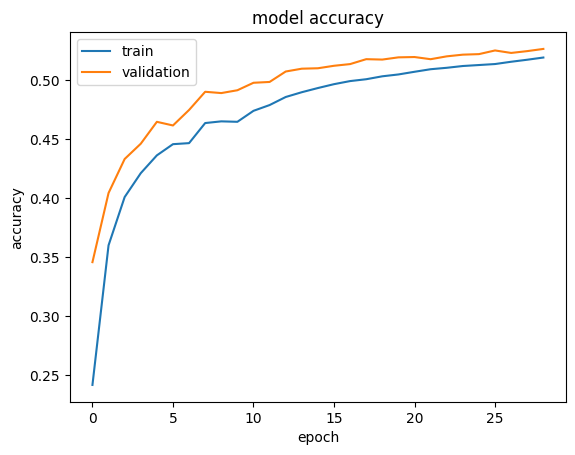

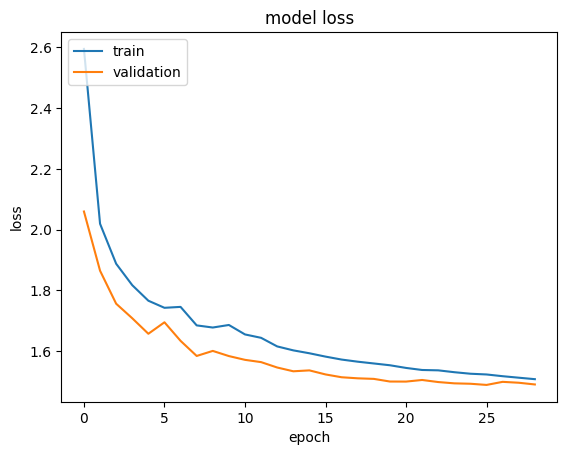

In [32]:
plot_accuracy(third_history)
plot_loss(third_history)

In [33]:
print("Evaluation of the third model: ")
third_model_loss, third_model_accuracy = third_model.evaluate (x_test, y_test, verbose=0)
print(f"Test loss: {third_model_loss}, Test accuracy: {third_model_accuracy}")

Evaluation of the third model: 
Test loss: 1.4931097030639648, Test accuracy: 0.5219837427139282


We can see that this model is not overfitting and is performing well in terms of generalization. Therefore, it could be a good choice compared to the other models, as it is significantly smaller.

#**Comparison**
Let’s now summarize all the results obtained so that we can easily visualize the differences between the various models

In [34]:
score_reference = model.evaluate(x_test, y_test, verbose=0)
score_first = first_model.evaluate(x_test, y_test, verbose=0)
score_second = second_model.evaluate(x_test, y_test, verbose=0)
score_third = third_model.evaluate(x_test, y_test, verbose=0)


In [35]:
acc_reference = round(score_reference[1],6)
acc_first = round(score_first[1], 6)
acc_second = round(score_second[1],6)
acc_third = round(score_third[1],6)

print(f"Accuracy of the reference model: {acc_reference}")
print(f"Accuracy of the first model: {acc_first}")
print(f"Accuracy of the second model: {acc_second}")
print(f"Accuracy of the third model: {acc_third}")

Accuracy of the reference model: 0.469846
Accuracy of the first model: 0.5098
Accuracy of the second model: 0.534794
Accuracy of the third model: 0.521984


Let's now generate a plot showing accuracy on y axis and training time on x axis:

In [36]:
param_reference = model.count_params()
param_first = first_model.count_params()
param_second = second_model.count_params()
param_third = third_model.count_params()

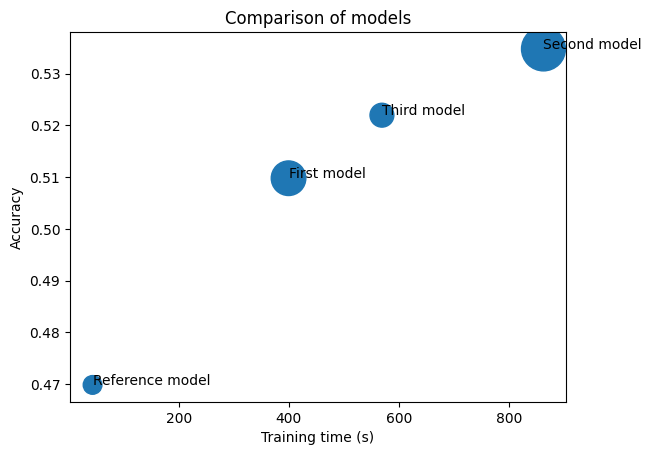

In [37]:
acc_list = [acc_reference, acc_first, acc_second, acc_third]
time_list = [time_reference, time_first, time_second, time_third]
params_list = [param_reference, param_first, param_second, param_third]

norm_params_list = [int(float(p)/max(params_list)*1000) for p in params_list]

labels = ['Reference model', 'First model', 'Second model', 'Third model']

fig, ax  = plt.subplots()
ax.scatter(time_list, acc_list, s=norm_params_list)
for i, label in enumerate(labels):
  ax.annotate(label, (time_list[i], acc_list[i]))

plt.ylabel('Accuracy')
plt.xlabel('Training time (s)')
plt.title('Comparison of models')
plt.show()

We can see that the second model achieves better accuracy than the others. The third model is a little faster but has a lower accuracy than the second and it uses fewer parameters, making it a suitable choice in certain situations